The world of trading can be treacherous and practically impossible to keep up with. However, with the recent introduction of commision-free trading platforms like Robinhood, participating in the stock market on a regular basis has because realistic for more people (like me!). 

After getting used to the terminology and platform, I realised the potential and power services like Robinhood provide with regards to taking control of your financials. But, there was one problem. I never quite felt like I was making informed decisions. Without confidence in my trades, I felt as though I was gambling, rather than trading.

Since I'm aiming to be a casual trader, I pondered how this could be automated and the most profitable trends found without years of market research or an fancy degree. To my surprise, a potential answer came to my attention through Kaggle's Data Notes email.

In a [post](https://www.kaggle.com/janiobachmann/s-p-500-simple-forecasting-with-prophet) to the [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500) dataset on Kaggle, [@janiobachmann](https://www.kaggle.com/janiobachmann) provides a quick demonstration on how to use [Prophet](https://facebook.github.io/prophet/) to make stock predictions.

From the Prophet website:
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In this post, I decided to take @janiobachmann's work one step further by making a queryable algorithm that uses the predictions from Prophet to help inform my trading decisions.

When making the algorithm, I considered the following:
- large brokerages are sometimes literally plugged into Wall Street and they will outtrade you due to their latency advantage
- if a trader wants to execute more than four day trades in a week, they need at least 25k in their account
- prediction error usually increases exponentially when extrapolating outside of a dataset's domain

From the first two factors, it's clear to see that short-range price action prediction has limited viability. Furthermore, long-range also has a relatively no probability of being successful. Therefore, my best option is to try my hand at mid-term prediction.

Speaking of options, options would be a great way to validate the algorithm! Not only are the three to five day options the cheapest, but that time range is ideal for the model.

In [8]:
import pandas as pd
from pandas_datareader import data, wb
import datetime as dt
from fbprophet import Prophet
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [6]:
# get list of company metadata
companies = pd.read_csv('companylist.csv')
companies.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,PIH,"1347 Property Insurance Holdings, Inc.",7.7000,4.608270e+07,NaN,2014.0,Finance,Property-Casualty Insurers,https://www.nasdaq.com/symbol/pih,NaN
1,PIHPP,"1347 Property Insurance Holdings, Inc.",25.8473,0.000000e+00,NaN,NaN,Finance,Property-Casualty Insurers,https://www.nasdaq.com/symbol/pihpp,NaN
2,TURN,180 Degree Capital Corp.,2.2900,7.126838e+07,NaN,NaN,Finance,Finance/Investors Services,https://www.nasdaq.com/symbol/turn,NaN
3,FLWS,"1-800 FLOWERS.COM, Inc.",12.8500,8.301617e+08,NaN,1999.0,Consumer Services,Other Specialty Stores,https://www.nasdaq.com/symbol/flws,NaN
4,FCCY,1st Constitution Bancorp (NJ),21.6500,1.810690e+08,NaN,NaN,Finance,Savings Institutions,https://www.nasdaq.com/symbol/fccy,NaN


In [7]:
# create start and end dates for stock data query
start = dt.datetime.now() - dt.timedelta(days=365*5)
end = dt.datetime.now()

In [10]:
actions = []
for index, row in companies.iterrows():
    current = data.DataReader(row.Symbol, 'iex', dt.datetime.now() - dt.timedelta(days=3), dt.datetime.now())
    
    try:
        last_close = current['close'].values[0]
    except:
        continue
    
    if last_close > 5.0:
        continue
    
    stock_raw = data.DataReader(row.Symbol, 'iex', dt.datetime.now() - dt.timedelta(days=365*5), dt.datetime.now())

    # skip stocks with NaN in history
    if stock_raw.isnull().values.any():
        continue
        
    # convert datetimes
    stock_raw.reset_index(inplace=True)
    stock_df = stock_raw.copy()
    stock_df.loc[:, 'date'] = pd.to_datetime(stock_raw.loc[:,'date'], format="%Y-%m-%d")
        
    # prepare data for prophet
    ph_df = stock_df.drop(['open', 'high', 'low', 'volume'], axis=1)
    ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)
    
    # fit data using prophet model
    m = Prophet()
    m.fit(ph_df)
    
    # create future dates
    future_prices = m.make_future_dataframe(periods=365)

    # predict prices
    forecast = m.predict(future_prices)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # view results
#     starting_date1 = mdates.date2num(start)
#     trend_date1 = mdates.date2num(end)
    
#     fig = m.plot(forecast)
#     ax1 = fig.add_subplot(111)
#     ax1.set_title(str(row.Symbol) + " Stock Price Forecast", fontsize=16)
#     ax1.set_xlabel("Date", fontsize=12)
#     ax1.set_ylabel("Close Price", fontsize=12)
    
#     fig2 = m.plot_components(forecast)
#     plt.show()

    # calculate predicted returns for this week
    end_of_week = dt.datetime.now() + dt.timedelta(days=6)
    
    future_close_max = forecast.loc[forecast.ds > end_of_week].iloc[0].yhat_upper
    future_close_expected = forecast.loc[forecast.ds > end_of_week].iloc[0].yhat
    future_close_min = forecast.loc[forecast.ds > end_of_week].ilosc[0].yhat_lower
    
    # calculate percent changes based on predictions
    max_move = (future_close_max - last_close)/last_close
    expected_move = (future_close_expected - last_close)/last_close
    min_move = (future_close_min - last_close)/last_close

    # calculate partition for gain and loss
    spread = abs(max_move - min_move)
    if max_move < 0:
        gain_partition = 0
        loss_partition = 100
    elif min_move > 0:
        gain_partition = 100
        loss_partition = 0
    else:
        gain_partition = max_move / spread
        loss_partition = abs(min_move) / spread
    
    # determine potential trades
    if expected_move > 5 and gain_partition > 67:
        actions.append({ "ticker": row.Symbol, "action": "STRONG CALL" })
        
    elif expected_move > 0 and gain_partition > 50:
        actions.append({ "ticker": row.Symbol, "action": "WEAK CALL" })
        
    elif expected_move < 0 and loss_partition > 50:
        actions.append({ "ticker": row.Symbol, "action": "WEAK PUT" })
    
    elif expected_move < -5 and loss_partition > 67:
        actions.append({ "ticker": row.Symbol, "action": "STRONG PUT" })
    
pd.DataFrame(actions).to_csv("trades.csv", index=False)
    

1y
1y
1y
5y


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/sean/.virtualenvs/ml/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [47]:
def make_predictions(ticker, daysOut=7, showCharts=False):
    # create start and end dates for stock data query
    start = dt.datetime.now() - dt.timedelta(days=365*5)
    end = dt.datetime.now()
    
    # get raw open, high, low, close, volume data
    stock_raw = data.DataReader(ticker, 'iex', dt.datetime.now() - dt.timedelta(days=365*5), dt.datetime.now())

    # skip stocks with NaN in history
    if stock_raw.isnull().values.any():
        return False
    
    # get the last close price
    last_close = stock_raw['close'].values[-1]
        
    # convert datetimes
    stock_raw.reset_index(inplace=True)
    stock_df = stock_raw.copy()
    stock_df.loc[:, 'date'] = pd.to_datetime(stock_raw.loc[:,'date'], format="%Y-%m-%d")
        
    # prepare data for prophet
    ph_df = stock_df.drop(['open', 'high', 'low', 'volume'], axis=1)
    ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)
    
    # fit data using prophet model
    m = Prophet()
    m.fit(ph_df)
    
    # create future dates
    future_prices = m.make_future_dataframe(periods=365)

    # predict prices
    forecast = m.predict(future_prices)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    # calculate predicted returns
    end_of_period = dt.datetime.now() + dt.timedelta(days=daysOut)
    
    future_close_max = forecast.loc[forecast.ds > end_of_period].iloc[0].yhat_upper
    future_close_expected = forecast.loc[forecast.ds > end_of_period].iloc[0].yhat
    future_close_min = forecast.loc[forecast.ds > end_of_period].iloc[0].yhat_lower
    
    # calculate percent changes based on predictions
    max_move = (future_close_max - last_close)/last_close
    expected_move = (future_close_expected - last_close)/last_close
    min_move = (future_close_min - last_close)/last_close

    # calculate partition for gain and loss
    spread = abs(max_move - min_move)
    if max_move < 0:
        gain_partition = 0
        loss_partition = 100
    elif min_move > 0:
        gain_partition = 100
        loss_partition = 0
    else:
        gain_partition = max_move / spread
        loss_partition = abs(min_move) / spread
    
    # determine potential trades
    if expected_move > 5 and gain_partition > 67:
        print("STRONG CALL")
        
    elif expected_move > 0 and gain_partition > 50:
        print("WEAK CALL")
        
    elif expected_move < 0 and loss_partition > 50:
        print("WEAK PUT")
    
    elif expected_move < -5 and loss_partition > 67:
        print("STRONG PUT")
        
    # view results
    if showCharts:
        fig = m.plot(forecast)
        ax1 = fig.add_subplot(111)
        ax1.set_title(ticker + " Stock Price Forecast", fontsize=16)
        ax1.set_xlabel("Date", fontsize=12)
        ax1.set_ylabel("Close Price", fontsize=12)

        # Second Subplot
        fig2, ax2 = plt.subplots()
        ax2.pie([gain_partition, loss_partition], labels=['gain', 'loss'])
        ax2.set_title("Amazon High Price History")

        fig2 = m.plot_components(forecast)
        plt.show()

5y


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/sean/.virtualenvs/ml/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/sean/.virtualenvs/ml/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


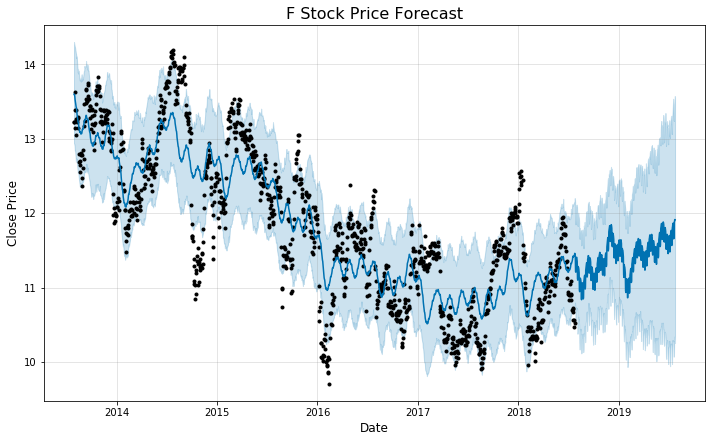

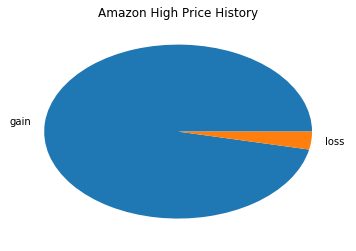

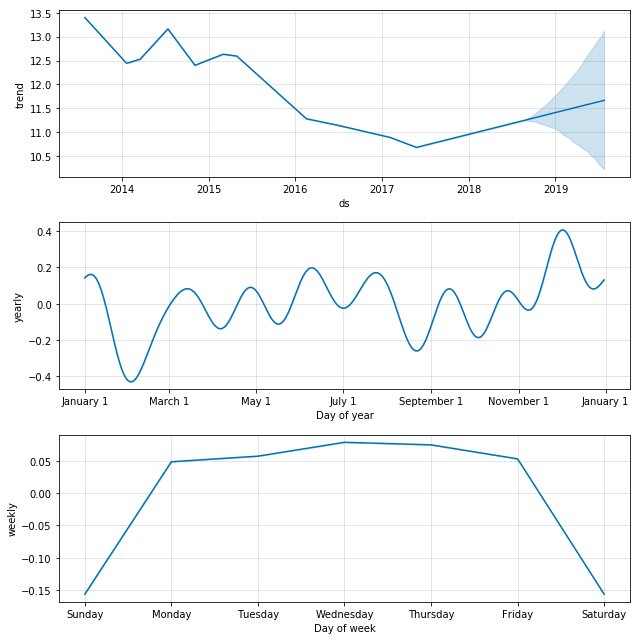

In [48]:
make_predictions('F', 250, True)